In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from explore.env.mujoco_sim import MjSim
from explore.utils.vis import AdjMap, play_path

# dataset = "../data/Pandas/rs-4e5"
# mujoco_xml = "../configs/franka_emika_panda/scene.xml"

dataset = "../data/twoFingerStart1"
mujoco_xml = "../configs/twoFingers.xml"

config_path = os.path.join(dataset, ".hydra/config.yaml")
cfg = OmegaConf.load(config_path)

ERROR_THRESH = cfg.RRT.min_cost
look_at_specific_start_idx = cfg.RRT.start_idx
look_at_specific_end_idx = cfg.RRT.end_idx
look_at_specific_end_idx = -1

print(f"Looking at start_idx {look_at_specific_start_idx} and end_idx {look_at_specific_end_idx} with error threshold {ERROR_THRESH}.")

Looking at start_idx 1 and end_idx -1 with error threshold 0.05.


## Load data

In [2]:
tree_dataset = os.path.join(dataset, "trees")
tree_count = len(os.listdir(tree_dataset))
print(f"Tree Count: {tree_count}")
trees: list[list[dict]] = []

total_nodes_count = 0
for i in range(tree_count):
    data_path = os.path.join(tree_dataset, f"tree_{i}.pkl")
    with open(data_path, "rb") as f:
        tree: list[dict] = pickle.load(f)
        trees.append(tree)
        total_nodes_count += len(tree)

print("Loaded ", total_nodes_count, " RRT nodes.")

Tree Count: 100
Loaded  2100  RRT nodes.


## Costs for all config pairs (without clustering)

100%|██████████| 100/100 [00:00<00:00, 449.00it/s]


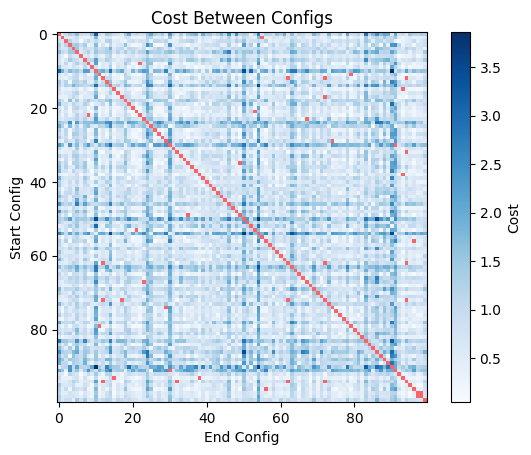

In [3]:
top_nodes = []
min_costs = []
for i in tqdm(range(tree_count)):

    tree_min_costs = [float("inf") for _ in range(tree_count)]
    tree_top_nodes = [-1 for _ in range(tree_count)]
    
    for n, node in enumerate(trees[i]):
        for j in range(tree_count):
            e = trees[j][0]["state"][1] - node["state"][1]
            node_cost = e.T @ e
            if node_cost < tree_min_costs[j]:
                tree_min_costs[j] = node_cost
                tree_top_nodes[j] = n
    
    top_nodes.append(tree_top_nodes)
    min_costs.append(tree_min_costs)

min_costs = np.array(min_costs)

AdjMap(min_costs, ERROR_THRESH, min_costs.max())

## Clustering

In [4]:
colors = [-1 for _ in range(tree_count)]

max_color_idx = 0
for i in range(tree_count):
        
    if colors[i] == -1:
        colors[i] = max_color_idx
        max_color_idx += 1
        
        for j in range(tree_count):
            if i != j and min_costs[i][j] <= ERROR_THRESH:
                if colors[j] != -1:
                    c = colors[j]
                    for k in range(tree_count):
                        if colors[k] == c:
                            colors[k] = colors[i]
                else:
                    colors[j] = colors[i]

groups = []
for c in colors:
    if not c in groups:
        groups.append(c)

group_sizes = [0 for _ in groups]
for c in colors:
    group_sizes[groups.index(c)] += 1

# print(colors)
# print(groups)
print("Group Count: ", len(groups))
print("Group Sizes: ", group_sizes)

Group Count:  83
Group Sizes:  [1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 6, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]


## Looking at specific start and end configurations

Mean costs for start config 1: 0.604065027480659, (Min: 0.048456497999122106, Max 1.7575188636437757)


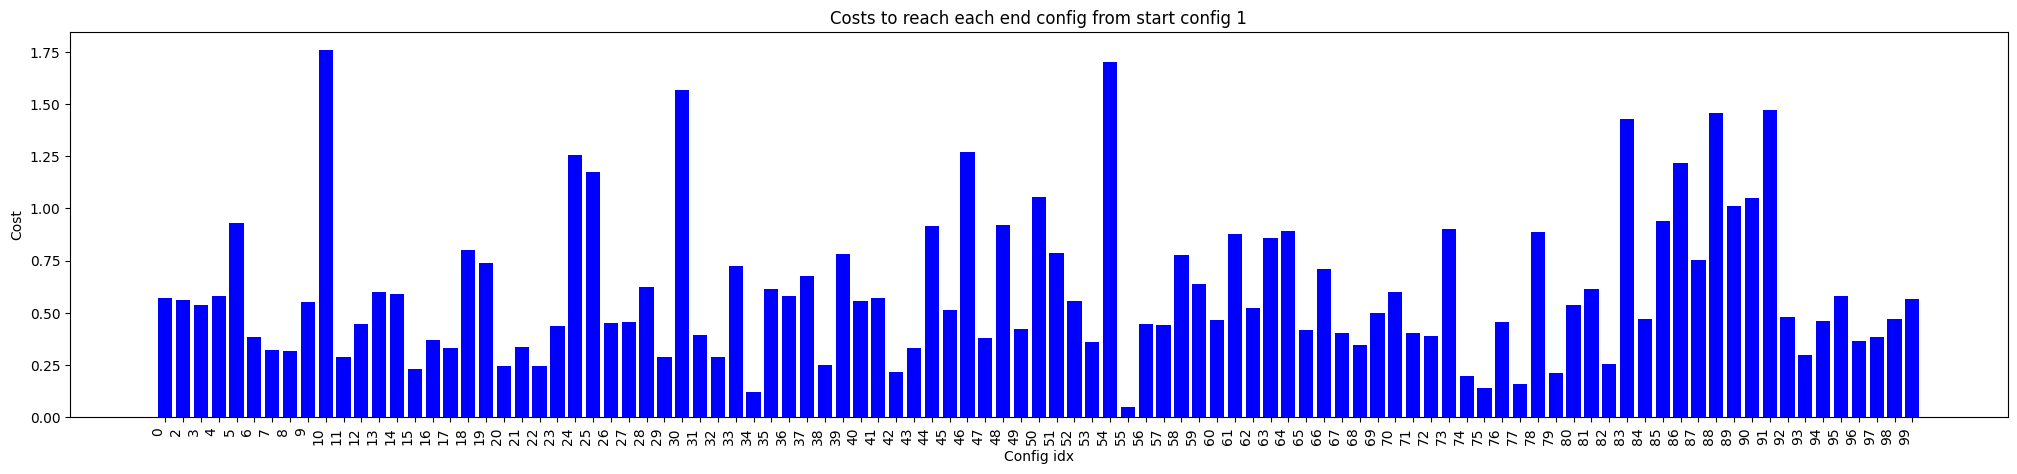

In [5]:
start_idx = look_at_specific_start_idx
end_idx = look_at_specific_end_idx

if look_at_specific_start_idx != -1:
    costs = [min_costs[start_idx][i] for i in range(tree_count) if start_idx != i]
    print(f"Mean costs for start config {start_idx}: {sum(costs)/tree_count}, (Min: {min(costs)}, Max {max(costs)})")
    labels = [str(i) for i in range(tree_count) if i != start_idx]
    
    highlight_labels = {str(end_idx)}
    colors = ["red" if label in highlight_labels else "blue" for label in labels]
    plt.figure(figsize=(25, 5))
    plt.bar(labels, costs, color=colors)
    plt.xticks(rotation=90, ha="right")
    plt.title(f"Costs to reach each end config from start config {start_idx}")
    plt.xlabel("Config idx")
    plt.ylabel("Cost")
    plt.show()

    if end_idx != -1:
        print(f"Cost for target {end_idx} with start {start_idx}: {costs[end_idx]}")

## Collecting top paths

In [6]:
top_paths_data = []
top_costs = []
for i in range(tree_count):
    for j in range(tree_count):
        if look_at_specific_start_idx != -1 and i != look_at_specific_start_idx:
            continue
        if look_at_specific_end_idx != -1 and j != look_at_specific_end_idx:
            continue

        if (
            (look_at_specific_end_idx != -1 and look_at_specific_end_idx != -1) or
            (min_costs[i][j] < ERROR_THRESH and i != j)
            ):
            top_paths_data.append(
                ((i, j), top_nodes[i][j])
            )
            top_costs.append(min_costs[i][j])
top_paths = []
top_paths_start = []
top_paths_goal = []
for path_data in top_paths_data:

    start_idx = path_data[0][0]
    end_idx = path_data[0][1]
    if start_idx == end_idx: continue
    
    tree = trees[start_idx]
    
    node = tree[path_data[1]]
    path = []
    
    while True:
        path.append(node)
        if node["parent"] == -1: break
        node = tree[node["parent"]]
    
    path.reverse()
    assert path[0] == tree[0]

    top_paths.append(path)
    top_paths_start.append(start_idx)
    top_paths_goal.append(end_idx)

target_counts = []
for i, path in enumerate(top_paths):
    goal_idx = top_paths_goal[i]
    target_counts.append(0)
    for node in path:
        if goal_idx == node["target_config_idx"]:
            target_counts[-1] += 1

percs = [float(np.round(c/len(top_paths[i])*100)) for i, c in enumerate(target_counts)]
percs.sort()
percs.reverse()

possible_paths = tree_count**2 - tree_count
print("Top costs: ", [float(c) for c in top_costs])
print("Found Trajectories Count: ", len(top_paths), " of ", possible_paths)
if look_at_specific_start_idx == -1:
    print("When considering full graph: ", sum([v**2 for v in group_sizes]) - tree_count, " of ", possible_paths)

if not len(top_paths):
    print("No trajectories found!")

else:
    print("Percentage of reached config used as target: ", percs)
    print("Avg. use of reached config as target: ", sum(percs)/len(percs))

    path_lens = [len(p) for p in top_paths]

    # print("Path lens: [", end="")
    # for i in range(len(top_paths)):
    #     end = "]\n" if i == len(top_paths)-1 else ", "
    #     print(f"{path_lens[i]} ({top_paths_start[i]}, {top_paths_goal[i]})", end=end)

    path_lens.sort()
    path_lens.reverse()
    print("Path lengths: ", path_lens)
    print("Avg. Path length: ", sum(path_lens)/len(path_lens))

Top costs:  [0.048456497999122106]
Found Trajectories Count:  1  of  9900
Percentage of reached config used as target:  [50.0]
Avg. use of reached config as target:  50.0
Path lengths:  [2]
Avg. Path length:  2.0


## Sample a single path

In [7]:
path = []
min_path_len = 2

valid_path_idxs = [i for i, l in enumerate(path_lens) if l >= min_path_len]

if not valid_path_idxs:
    print("No good paths no analyse!")

else:
    path_idx = np.random.choice(valid_path_idxs)
    path = top_paths[path_idx]
    start_idx = top_paths_start[path_idx]
    end_idx = top_paths_goal[path_idx]

    print("---- Sampled Path Data ----")
    print("Target config ids: ", [n["target_config_idx"] for n in path])
    print("Start idx: ", start_idx)
    print("End idx: ", end_idx)
    print("Cost: ", top_costs[path_idx])
    print("Error vec: ", trees[end_idx][0]["state"][1] - path[-1]["state"][1])
    print("Sampled Path Length: ", len(path))

---- Sampled Path Data ----
Target config ids:  [-1, 55]
Start idx:  1
End idx:  55
Cost:  0.048456497999122106
Error vec:  [ 0.0435926  -0.10902913 -0.11946657  0.04151685 -0.08388369  0.0674789
  0.04258835 -0.00172801  0.06806238  0.0003169  -0.02512141  0.00034499
  0.00158117]
Sampled Path Length:  2


In [8]:
if path:
    start_state = trees[start_idx][0]["state"][1]
    target_state = trees[end_idx][0]["state"][1]
    sim = MjSim(mujoco_xml, view=True)
    play_path(start_state, target_state, path.copy(), sim)

RuntimeError: `launch_passive` requires that the Python script be run under `mjpython` on macOS